## Ensure to add:
- Image file
- `.env` file before proceeding




In [1]:
!nvidia-smi

Mon Jan 29 10:51:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install deepface==0.0.80
!pip install matplotlib
!pip install cv2
!pip install face-recognition
!pip install openai
!pip install chromadb
!pip install replicate==0.22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=7170974d38704641b176c01b3db9788f2ca2e826a3baa820091b9b1c75649ceb
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-a

In [4]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd {HOME}

/content
/content/weights
/content


In [5]:
%cd {HOME}
!git clone https://github.com/ashrithjacob/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 352 (delta 120), reused 104 (delta 104), pack-reused 191
Receiving objects: 100% (352/352), 12.84 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━

In [6]:
import os
import groundingdino
import os
import supervision as sv
import torch
from torchvision.ops import box_convert
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import replicate
import chromadb
import openai
import json
import datetime
from chromadb.utils import embedding_functions
from chromadb.config import Settings
from dotenv import load_dotenv
from deepface import DeepFace
from deepface.commons import functions, realtime, distance as dst
from groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
)
from IPython.display import Image

24-01-29 10:55:09 - Directory /root/.deepface created
24-01-29 10:55:09 - Directory /root/.deepface/weights created


In [7]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

##INTEGRATED FACE AND PERSONA:

In [8]:
class GroundingDino:
    def __init__(self, scaling_factor, object_to_detect):
        self.HOME = os.getcwd()
        self.scaling_factor = scaling_factor
        self.CONFIG_PATH = os.path.join(
            self.HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
        )

        if (self.CONFIG_PATH, "; exist:", os.path.isfile(self.CONFIG_PATH)):
            self.WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
            self.WEIGHTS_PATH = os.path.join(self.HOME, "weights", self.WEIGHTS_NAME)
            self.MODEL = load_model(self.CONFIG_PATH, self.WEIGHTS_PATH)
        self.object_to_detect = object_to_detect
        self.name_head = self.acronym(object_to_detect)

    """
    uses grounding dinos to box faces
    """
    def acronym(self, object_to_detect):
        first_letters = [word[0] for word in object_to_detect.split()]
        return ("".join(first_letters))

    def _box_face(
        self,
        image_path,
        text_prompt,
        box_threshold=0.3,
        text_threshold=0.25,
    ):
        image_source, image = load_image(image_path)
        boxes, logits, phrases = predict(
            model=self.MODEL,
            image=image,
            caption=text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
        )
        return {
            "image": image_source,
            "boxes": boxes,
            "logits": logits,
            "phrases": phrases,
        }

    def inflate_box(self, boxes):
        boxes[:, 2:] *= self.scaling_factor  # scaling factor(fix box overlap issues)
        return boxes

    def display(self, image_path):
        properties = self._box_face(image_path=image_path, text_prompt=self.object_to_detect)
        annotated_frame = annotate(
            image_source=properties["image"],
            boxes=properties["boxes"],
            logits=properties["logits"],
            phrases=properties["phrases"],
        )
        sv.plot_image(annotated_frame, (16, 16))

    def get_xyxy_mask(self, image_path):
        properties = self._box_face(image_path=image_path, text_prompt=self.object_to_detect)
        img = properties["image"]
        boxes = properties["boxes"]
        boxes = self.inflate_box(boxes)
        h, w, _ = img.shape
        boxes = boxes * torch.Tensor([w, h, w, h])
        xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
        xyxy = [tuple(map(int, map(round, mask))) for mask in xyxy]
        return img, xyxy, properties["logits"]

    def crop(self, image_path):
        img_list = []
        img, masks, fid_score = self.get_xyxy_mask(image_path)
        for mask in masks:
            x1, y1, x2, y2 = map(int, map(round, mask))
            img_list.append(img[y1:y2, x1:x2])
        return img_list, fid_score

    def save_cropped_images_with_fidelity_score(self, image_path):
        crops = []
        img_name = image_path.split("/")[-1]
        cropped_images, fid_score = self.crop(image_path)
        for i in range(len(cropped_images)):
            fname = f"{self.name_head}-{i}-{img_name}"
            crops.append(fname)
            plt.imsave(fname, cropped_images[i])
            print(f"img cropped and saved as:'{fname}'")
        return crops, fid_score



class FaceRecognition:
    def __init__(self):
        self.backends = [
            "opencv",
            "ssd",
            "dlib",
            "mtcnn",
            "retinaface",
            "mediapipe",
            "yolov8",
            "yunet",
            "fastmtcnn",
        ]
        self.models = [
            "VGG-Face",
            "Facenet",
            "Facenet512",
            "OpenFace",
            "DeepFace",
            "DeepID",
            "ArcFace",
            "Dlib",
            "SFace",
        ]

        self.face_store = {}

        # setup Chroma in-memory, for easy prototyping. Can add persistence easily!
        #self.client = chromadb.Client(Settings(persist_directory="./"))
        # Create collection. get_collection, get_or_create_collection, delete_collection also available!
        #self.collection = self.client.get_or_create_collection(
            #"face", embedding_function=openai_ef
        #)

    """
    use deepface to box faces
    """
    def deepface_box_face(self, image_path):
        boxes = []
        phrase = []
        confidence = []
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name=self.models[2],
            detector_backend=self.backends[4],
            enforce_detection=True,
        )
        image_source, _ = load_image(image_path)
        h, w, _ = image_source.shape
        for e in embedding_obj:
            box = list(e["facial_area"].values())
            box = [x / w if i % 2 == 0 else x / h for i, x in enumerate(box)]
            box[0] += box[2] / 2
            box[1] += box[3] / 2
            boxes.append(box)
            confidence.append(e["face_confidence"])
            phrase.append("face_confidence")
        return {
            "image": image_source,
            "boxes": torch.Tensor(boxes),
            "logits": torch.Tensor(confidence),
            "phrases": phrase,
        }

    def display_deepface(self, image_path):
        properties = self.deepface_box_face(image_path=image_path)
        annotated_frame = annotate(
            image_source=properties["image"],
            boxes=properties["boxes"],
            logits=properties["logits"],
            phrases=properties["phrases"],
        )
        sv.plot_image(annotated_frame, (16, 16))

    def create_face_embedding(self, image_path):
        embeddings = []
        embedding_obj = DeepFace.represent(
            img_path=image_path,
            model_name=self.models[2],
            detector_backend=self.backends[4],
            enforce_detection=False,
        )
        embeddings = [e["embedding"] for e in embedding_obj]
        return embeddings

    def get_embedding(self, image_path):
        emb = {}
        embeddings=self.create_face_embedding(image_path)
        emb[image_path]=embeddings
        return emb

    def check_match(self, face):
        threshold = 25
        for name in self.face_store.keys():
            name_embedding = self.face_store[name][0]["embedding"]
            distance = dst.findEuclideanDistance(name_embedding, face)
            print(f'distance with {name}:{distance}')
            if distance < threshold:
                return {"value":name, "status":True}
        return {"value":None, "status":False}

    def register_new_name(self, fid, face, name=None):
        temp = {}
        if name == None:
            name = input("register a name for the image based on face: \t")
        temp[name] = [{"fid":fid, "embedding":face}]
        print(f'saved {name} into face store')
        self.face_store =  self.face_store | temp
        return name

In [9]:
class PersonaRecognition:
    def __init__(self, path_to_db="./"):
        openai_ef = embedding_functions.OpenAIEmbeddingFunction(
            api_key=os.getenv("OPENAI_API_KEY"), model_name="text-embedding-ada-002"
        )
        # setup Chroma in-memory, for easy prototyping. Can add persistence easily!
        self.client = chromadb.Client(Settings(persist_directory="./"))
        # Create collection. get_collection, get_or_create_collection, delete_collection also available!
        self.collection = self.client.get_or_create_collection(
            "feature_store", embedding_function=openai_ef
        )
        self.client = chromadb.PersistentClient(path=path_to_db)
        self.results = None
        self.unknown_counter = 0

    def get_entry_numbers(self):
        number_of_entries = self.collection.count()
        return number_of_entries

    def delete_entries(self, ids):
        self.collection.delete(ids=ids)

    def refresh_db(self):
        self.unknown_counter = 0
        if self.get_entry_numbers():
            ids = [str(idx) for idx in range(self.get_entry_numbers())]
            self.delete_entries(ids)

    def replace_unknown_name(self, replace_with_name, unknown_name, time):
        if unknown_name.split("-")[0] == "unknown":
            replace_id = self.collection.get(where={"name": unknown_name})["ids"][0][0]
            self.collection.update(
                ids=[replace_id], metadatas=[{"name": replace_with_name, "time": time}]
            )

    def add(self, features, name, time):
        number_of_entries = self.get_entry_numbers()
        self.collection.add(
            documents=[
                str(features)
            ],  # we handle tokenization, embedding, and indexing automatically. You can skip that and add your own embeddings as well
            metadatas=[{"name": name, "time":time}],  # filter on these!
            ids=[str(number_of_entries)],  # unique for each document
        )

    def retrieve(self, query, n=2):
        results = self.collection.query(
            query_texts=query,
            n_results=n,
            # where={"metadata_field": "is_equal_to_this"}, # optional filter
            # where_document={"$contains":"search_string"}  # optional filter
        )
        return results

    def remove_none_values(self, input_dict):
        # Use dictionary comprehension to filter out key-value pairs with values equal to "none"
        filtered_dict = {
            key: value for key, value in input_dict.items() if value.lower() != "none"
        }
        return filtered_dict

    def get_embedding(self, text, model="text-embedding-ada-002"):
        text = text.replace("\n", " ")
        return openai.embeddings.create(input=[text], model=model).data[0].embedding

    def enrol_persona(self, features):
        name = input("register a name for the image based on persona: \t")
        self.add(features, name)
        print(f"{name} added successfully")
        return name

    def is_persona_match(results):
        threshold = 0.04
        if results:
            distances = results["distances"][0]
            print("Distance:", distances)
        if len(distances):
            return distances[0] < threshold
        return False

In [80]:
class ImageToTextModel:
    # See API to set temperature and top_p
    def __init__(
        self,
        api_url_replicate="naklecha/cogvlm:ec3886f9ea85dd0aee216585be5e6d07b04c9650f7b8b08363a14eb89e207eb2",
    ):
        self.model = "REPLICATE"
        self.api_url = api_url_replicate
        self.api = replicate.Client(api_token=os.getenv("REPLICATE_API_TOKEN"),)

    @classmethod
    def write_to_json(cls, data, json_file_path):
        # Check if the JSON file already exists
        if os.path.exists(json_file_path):
            # If the file exists, load its content and update it with new data
            with open(json_file_path, "r") as json_file:
                existing_data = json.load(json_file)
                existing_data.update(data)

            # Write the updated data back to the JSON file
            with open(json_file_path, "w") as json_file:
                json.dump(existing_data, json_file, indent=2)
        else:
            # If the file doesn't exist, create a new one with the current data
            with open(json_file_path, "w") as json_file:
                json.dump(data, json_file, indent=4)

    def get_description(self, image_path, prompt):
        output = self.api.run(
            self.api_url,
            input={
                "image": open(image_path, "rb"),
                "prompt": prompt,
            },
        )
        return output

    def run(self, image_path):
        prompt_1 = """
        Describe the person in this image. Namely regarding:
        - The person's race/ethnicity based on their physical features (categorize as african, white, east asian, middle-eastern or mixed).
        - The person's gender
        - The person's physique(their height and weight)
        If you're unclear of their perceived ethnicity say you do not know.
        """

        prompt_2 = """
        Describe the person in this image. Namely regarding:
        - The person's facial features
        - The person's hair colour (black, brown, blonde or red)
        - The person's attire
        - The person's jewelery
        """

        description_1 = self.get_description(image_path, prompt_1)
        description_2 = self.get_description(image_path, prompt_2)

        print("description 1:", description_1)
        print("description 2:", description_2)

        return(description_1 + description_2)

In [81]:
class Helper:
    def __init__(self, face_cropping, body_cropping, face_model, persona_model):
        self.face_cropping = face_cropping
        self.body_cropping = body_cropping
        self.face_model = face_model
        self.persona_model = persona_model

    # The following are placeholder functions for the actual implementations
    def read_text_file(file_path):
        try:
            with open(file_path, "r") as file:
                contents = file.read()
            return contents
        except Exception as e:
            print(f"Error encountered:{e}")
            return None

    def format_data_as_json(json_format, data):
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            response_format={"type": "json_object"},
            seed=19303,
            temperature=0.2,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that injests textual information and organize it as a json. render value as 'none' if no information is found and ensures to keep all the text in lowercase.",
                },
                {
                    "role": "user",
                    "content": f"organise the following data into  a json, with the following key values.\n format:{json_format}\n data:{data}.",
                },
            ],
        )
        return json.loads(response.choices[0].message.content)

    def remove_none_values(features_data):
        # Use dictionary comprehension to filter out key-value pairs with values equal to "none"
        filtered_dict = {
            key: value
            for key, value in features_data.items()
            if value.lower() != "none"
        }
        return filtered_dict

    def level_1_persona_threshold(features, human_fidelity):
        necessary_features = ["gender", "attire"]
        threshold = 0.3
        features_check = all(
            element in list(features.keys()) for element in necessary_features
        )
        if features_check and human_fidelity > threshold:
            return True
        else:
            return False

    def level_1_face_threshold(fidelity):
        threshold = 0.5
        return fidelity > threshold

    def get_face_feature(description):
        json_format = """
        {
        gender[male/masculine/man or female/feminine/woman]:
        ethnicity[one of the follows: african, east asian, white, middle-eastern, south asian and others]:
        physique:
        facial_hair:
        hair_colour:[either black, brown, blonde or red]
        attire:[with colour as well]
        jewelery:
        }
        """
        #folder = "./descriptions/"
        #file = image.split(".")[0] + ".txt"
        #data = Helper.read_text_file(f"{folder}{file}")
        features = Helper.format_data_as_json(json_format, description)
        features_filtered = Helper.remove_none_values(features)
        return {"raw": features, "filtered": features_filtered}

    def personality_match(query_results):
        threshold = 0.04
        if len(query_results["distances"][0]) !=0: #if not empty
            return (query_results["distances"][0][0] < threshold)
        else:
            return False

    def face_persona_match(name, persona_query_results):
        threshold = 0.05
        distances = persona_query_results["distances"][0]
        print("Distance:", distances)
        if len(distances):
            if distances[0] < threshold:
                print("NAME_FACE:", name.lower())
                print(
                    "NAME PERSONA:",
                    persona_query_results["metadatas"][0][0]["name"].lower(),
                )
                return (
                    name.lower()
                    == persona_query_results["metadatas"][0][0]["name"].lower()
                )
        return False
        # Implement the logic for persona matching with FACE match

    def level_2_face_threshold(fidelity):#0.9
        return fidelity > 0.9

    def level_2_persona_threshold(fidelity, features):#0.5
        threshold = 0.6
        number_of_necessary_features = 5
        number_of_current_features = len(list(features.keys()))
        reasons_for_rejection = []
        if fidelity <= threshold:
            status = False
            reasons_for_rejection.append("Persona Fidelity Issue")
        elif number_of_current_features < number_of_necessary_features:
            status = False
            reasons_for_rejection.append(
                f"Features fewer than threshold of {number_of_necessary_features}"
            )
        else:
            status = True
        return {"status": status, "reasons": reasons_for_rejection}

    def specific_result(results, idx):
        print(f"IDX:{idx}; RESULTS:{len(results['distances'][0])}")
        if idx < len(results['distances'][0]):#handle 0 results criterion
            selected_result = {
            'ids': [[results['ids'][0][idx]]],
            'distances': [[results['distances'][0][idx]]],
            'metadatas': [[results['metadatas'][0][idx]]],
            'embeddings': None,
            'documents': [[results['documents'][0][idx]]],
            'uris': None,
            'data': None
            }
            return selected_result
        return None

    def time_process(results, current_time):
        minutes_threshold = 30
        format ="%m/%d/%Y %H:%M:%S"
        current_time=datetime.datetime.strptime(current_time, format)#in datetime format
        for idx, r in enumerate(results["metadatas"][0]):
            time = r["time"]
            date_obj = datetime.datetime.strptime(time, format)
            diff_time = current_time - date_obj
            diff_minutes = diff_time.total_seconds() / 60
            print("diff miuites:",diff_minutes)
            if diff_minutes < minutes_threshold:
                selected_result = Helper.specific_result(results, idx)
                return selected_result
        return Helper.specific_result(results, 0)

# only enrolment can modify dbs
class Enrollment:
    def __init__(self, face_model, persona_model, matching):
        self.face_model = face_model
        self.persona_model = persona_model
        self.matching = matching

    def run(self, face_fidelity, face_emb, persona_feature, persona_fidelity, current_time):
        is_level_2_face = Helper.level_2_face_threshold(face_fidelity)
        is_level_2_persona = Helper.level_2_persona_threshold(
            persona_fidelity, persona_feature
        )["status"]

        if is_level_2_face and is_level_2_persona:#level 2 face and persona
            name = self.face_model.register_new_name(face_fidelity, face_emb)
            self.persona_model.add(persona_feature, name, current_time)
            print(f" Admitted {name} into face and persona db")
        elif is_level_2_persona:# only level 2 persona
            unknown_name = f"unknown-{self.persona_model.unknown_counter}"
            self.persona_model.add(persona_feature, unknown_name, current_time)
            self.persona_model.unknown_counter += 1
            print(f"Addmitted '{unknown_name}' added to persona db")
        elif is_level_2_face:# only level 2 face
            replace_with_name = self.face_model.register_new_name(
                face_fidelity, face_emb
            )
            print(f" Admitted {replace_with_name} into face db")
            unknown_name = self.matching.persona_match(persona_feature, persona_fidelity, current_time)["name"]
            if unknown_name is not None:
                self.persona_model.replace_unknown_name(replace_with_name, unknown_name, current_time)
                print(f"Replaced {unknown_name} with {replace_with_name} from persona db")


class Matching:
    def __init__(self, face_model, persona_model):
        self.face_model = face_model
        self.persona_model = persona_model

    def face_match(self, face_fidelity, face_emb):
        if Helper.level_1_face_threshold(face_fidelity):
            face_match = self.face_model.check_match(face_emb)
            if face_match["status"]:
                return face_match["value"]
            else:
                return None

    def persona_match(self, persona_feature, persona_fidelity, current_time):
        if Helper.level_1_persona_threshold(persona_feature, persona_fidelity):
            number_of_results = 10
            results = self.persona_model.retrieve(str(persona_feature), n=number_of_results)
            results = Helper.time_process(results, current_time)
            if results is not None:
                if Helper.personality_match(results):
                    return {
                        "name": results["metadatas"][0][0]["name"],
                        "distance": results["distances"][0][0],
                        "id": results["ids"][0][0],
                          }
        return {
                "name": None,
                "distance": None,
                "id": None
                }

    def run(self, face_fidelity, face_emb, persona_feature,persona_fidelity, current_time):
        match_dict = {
            "face_name":None,
            "persona_name": None }
        if Helper.level_1_face_threshold(face_fidelity):
            match_dict["face_name"] = self.face_match(face_fidelity, face_emb)
        if Helper.level_1_persona_threshold(persona_feature, persona_fidelity):
            match_dict["persona_name"] = self.persona_match(persona_feature, persona_fidelity, current_time)
        return match_dict


In [82]:
#initialise objects and DB
%cd {HOME}
cogvlm_model = ImageToTextModel()
face_cropping = GroundingDino(scaling_factor=1.7, object_to_detect="human face")
body_cropping = GroundingDino(scaling_factor=1.0, object_to_detect="human body")
face_model = FaceRecognition()
persona_model = PersonaRecognition()

/content
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased


In [83]:
matching = Matching(face_model, persona_model)
enrollment = Enrollment(face_model, persona_model, matching)

In [84]:
# initialize stores
face_model.face_store = {}
image_folder ="./"
persona_model.refresh_db()
print("number of entries in persona db =", persona_model.get_entry_numbers())

number of entries in persona db = 0


# Looping from here

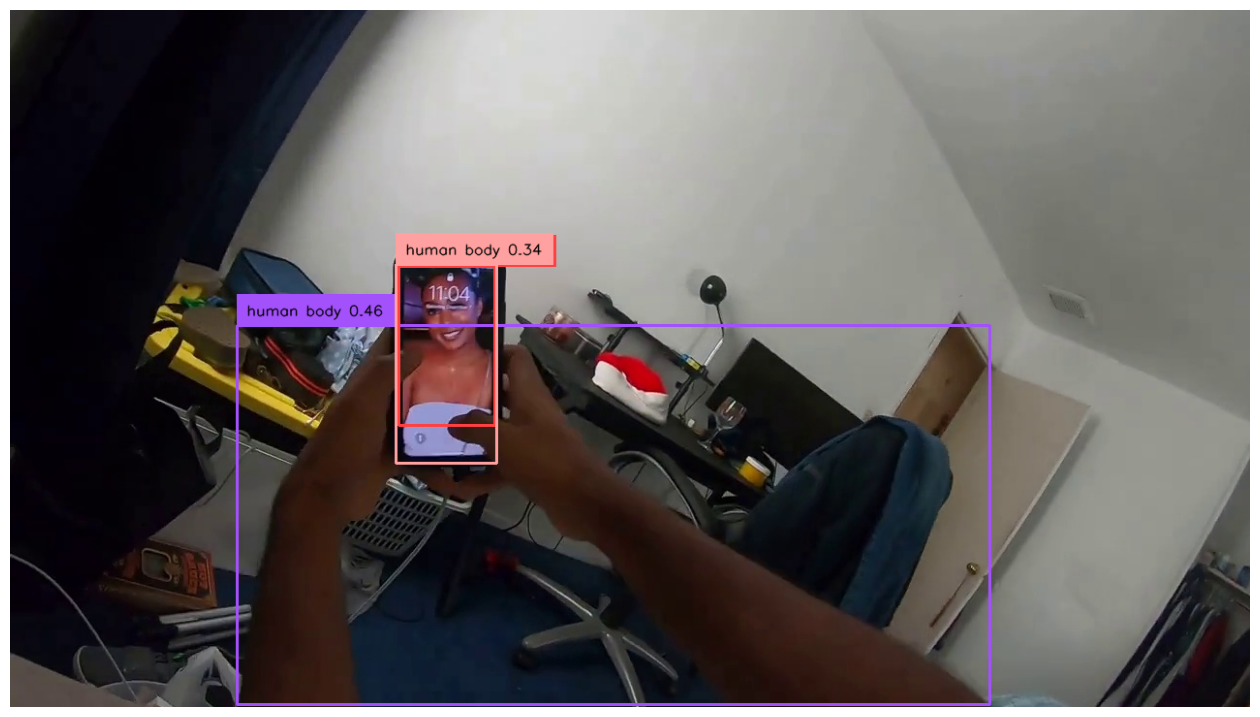

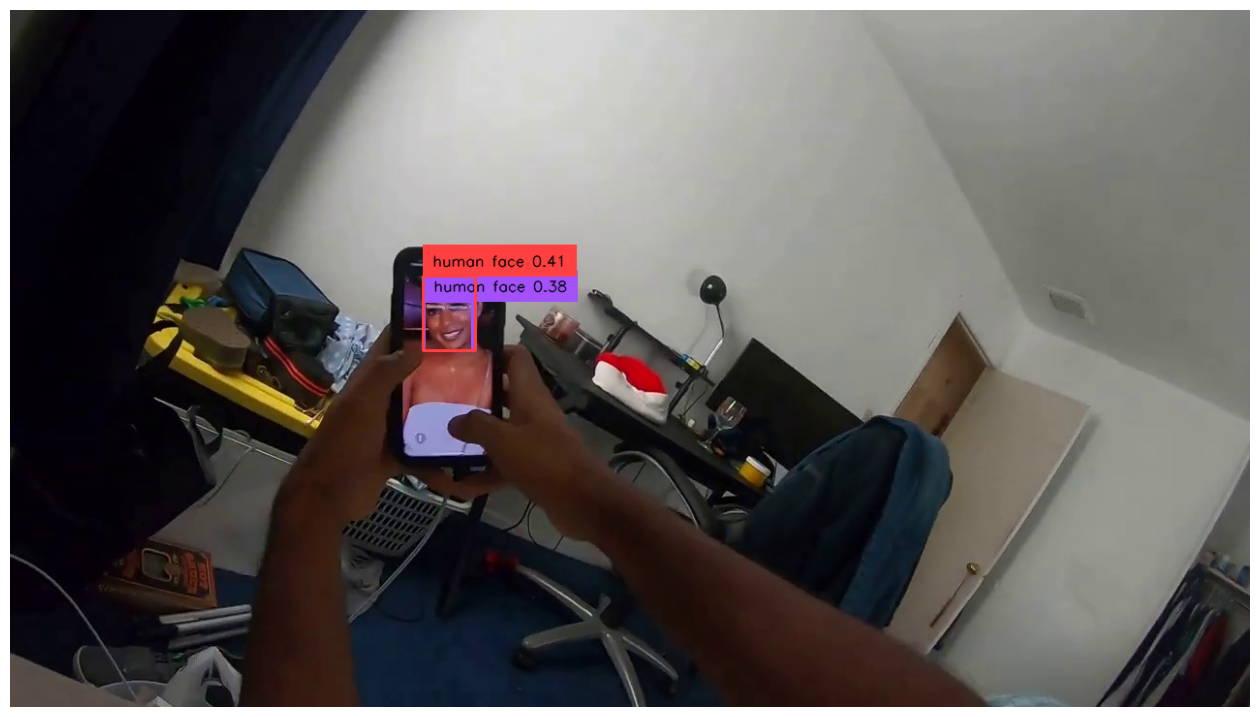

img cropped and saved as:'hb-0-img-2.jpg'
img cropped and saved as:'hb-1-img-2.jpg'
img cropped and saved as:'hb-2-img-2.jpg'
img cropped and saved as:'hf-0-img-2.jpg'
img cropped and saved as:'hf-1-img-2.jpg'
body_cropped_file_names:['hb-0-img-2.jpg', 'hb-1-img-2.jpg', 'hb-2-img-2.jpg']
fidelity scores:tensor([0.4648, 0.3728, 0.3355])


In [111]:
#90, 73, 69, 71, 95
img = "img-2.jpg"
img_path = f'{image_folder}{img}'

body_cropping.display(img_path)
face_cropping.display(img_path)
body_images_cropped, body_fidelity = body_cropping.save_cropped_images_with_fidelity_score(img_path)
face_images_cropped, face_fidelity = face_cropping.save_cropped_images_with_fidelity_score(img_path)
_, masks, _ = body_cropping.get_xyxy_mask(img_path)
print(f"body_cropped_file_names:{body_images_cropped}\nfidelity scores:{body_fidelity}")

In [115]:
# below is run manually for now
# find_non_overlapping_person() --> find all crops that don't have `majority` of another crop in it --> return list of indices(valid_idx) that are valid crops
# can also prompt cogvlm to return the number of people in the images (expensive option)
# cropped_and_fidelity = [(cropped_images_names[i],fid_score[i]) for i in valid_idx]
#folder = "./descriptions/"
#files = os.listdir(folder)
cropped_and_fidelity_persona = []
cropped_and_fidelity_face = []
for idx, c_img in enumerate(body_images_cropped):
    try:
        cropped_and_fidelity_persona.append((body_images_cropped[idx], body_fidelity[idx]))
        cropped_and_fidelity_face.append((face_images_cropped[idx], face_fidelity[idx])) # Assuming we have a one to one body to face mapping
    except Exception as e:
        print(f"Body and face mismatch:{e}")
print(cropped_and_fidelity_persona)
print(cropped_and_fidelity_face)

Body and face mismatch:list index out of range
[('hb-0-img-2.jpg', tensor(0.4648)), ('hb-1-img-2.jpg', tensor(0.3728)), ('hb-2-img-2.jpg', tensor(0.3355))]
[('hf-0-img-2.jpg', tensor(0.3811)), ('hf-1-img-2.jpg', tensor(0.4109))]


In [110]:
for body, face in zip(cropped_and_fidelity_persona, cropped_and_fidelity_face):
    format ="%m/%d/%Y %H:%M:%S"
    current_time = datetime.datetime.now()
    current_time = current_time.strftime(format)

    cropped_image_face = face[0]
    cropped_image_persona = body[0]
    face_fidelity = face[1]
    persona_fidelity = body[1]
    print(f"Persona:{persona_fidelity};\n Face:{face_fidelity}")
    print(f"Current time:{current_time}")

    # face feature injestion
    description = cogvlm_model.run(f"{image_folder}/{cropped_image_persona}")
    persona_feature = Helper.get_face_feature(description)["filtered"] # can also try "raw"
    print("persona features:", persona_feature)

    # face embedding and matching
    face_emb = face_model.create_face_embedding(cropped_image_face)[0]
    face_match = face_model.check_match(face_emb)

    # retrieve top n persona from db based on feature
    #persona.results = persona.retrieve(str(persona_feature), n=1)
    matches=matching.run(face_fidelity, face_emb, persona_feature, persona_fidelity, current_time)
    print("MATCHES",matches)
    if matches["face_name"] != None:
      if (matches["face_name"] == matches["persona_name"]["name"]):
          print(f"Match found:{matches['face_name']}")
    else:
        enrollment.run(face_fidelity, face_emb, persona_feature, persona_fidelity, current_time)

Persona:0.9140675067901611;
 Face:0.7814751267433167
Current time:01/29/2024 15:00:52
description 1: The person in the image appears to be of African descent. They have dark skin, a prominent nose, and their hair is pulled back into a bun. The person is also smiling and seems to be in a joyful mood.
description 2: The person in the image appears to be a young woman with a dark complexion. She has a radiant smile and her hair is tied up in a bun. She is wearing a black top and has a necklace on.
persona features: {'gender': 'female', 'ethnicity': 'african', 'hair_colour': 'black', 'attire': 'black top', 'jewelery': 'necklace'}


distance with james:29.14772481822044
distance with james:29.14772481822044
diff miuites: 13.616666666666667
IDX:0; RESULTS:2
MATCHES {'face_name': None, 'persona_name': {'name': None, 'distance': None, 'id': None}}
Addmitted 'unknown-1' added to persona db


In [88]:
print("number of entries in persona db =", persona_model.get_entry_numbers())
print("number of entries in face store =", face_model.face_store.keys())

number of entries in persona db = 1
number of entries in face store = dict_keys(['james'])
